In [10]:
import numpy as np
import pandas as pd
import os
import sys
import time
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.d01_data.fetch.fetch_fixations import fetch_fixations
from src.d03_processing.feature_calculate.transition_calculations import *
from src.d03_processing.feature_calculate.fix_sacc_calculations import n_fix, dwell_time
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Rectangle, Circle

In [11]:
# break down transition entropy, stationary entropy and KL distance to make sure correct

In [12]:
# https://dl.acm.org/doi/pdf/10.1145/2834121 READ THIS FOR BREAKDOWN OF ENTROPY GAZE MEASURES AND HOW TO CALCULATE

In [13]:
# stationary entropy
pi = [0.34, 0.12, 0.38, 0.16, 0, 0]  # sample distribution
print(pi / np.log2(len(pi)))
pi = [0.25, 0.25, 0.25, 0.25]  # uniform distribution has maximum entropy
SE = 0
for i in range(len(pi)):
    SE += pi[i] * np.log2(pi[i])
SE *= -1

print(SE)
    

[0.13152995 0.04642234 0.14700407 0.06189645 0.         0.        ]
2.0


In [14]:
pid = ['32', '33', '3']

all_fix = fetch_fixations(pid)
# print(all_fix.head(1))
viewings = np.unique(all_fix.viewing_id)
viewings = ['alloeye_32r3_8_enc', 'alloeye_33r1_8_enc', 'alloeye_3r2_10_enc']
# print(pid_ae)

study_id not in pid, altering pid
study_id not in pid, altering pid
study_id not in pid, altering pid
('all')

and ppt_id in ('alloeye_32', 'alloeye_33', 'alloeye_3')
executing query
SELECT * FROM "fixations_saccades" WHERE algorithm in ('VR_IDT') and ppt_id in ('alloeye_32', 'alloeye_33', 'alloeye_3')
- dataframe returned in 0.45984435081481934


alloeye_33r1_8_enc


,fixation_id,study_id,ppt_id,block_id,trial_id,viewing_id,algorithm,fixation_or_saccade,object,start_time,end_time,start_frame,end_frame,duration_time,duration_frame,invalid_duration,centroid_x,centroid_y,centroid_z,dispersion,mean_velocity,max_velocity,mean_acceleration,gaze_object_proportion,second_gaze_object,second_gaze_object_proportion,other_gaze_object_proportion,missing_split_group
0,alloeye_33r1_8_enc_VR_IDT_4986,alloeye,alloeye_33,alloeye_33r1,alloeye_33r1_8,alloeye_33r1_8_enc,VR_IDT,fixation,Pipe,381259.000000,381334.000000,45761,45770,75.000000,9,0.000000,0.068384,0.816093,-0.452709,0.006257,0.000305,0.000543,0.000014,1.000000,,0.000000,0.000000,0
1,alloeye_33r1_8_enc_VR_IDT_4989,alloeye,alloeye_33,alloeye_33r1,alloeye_33r1_8,alloeye_33r1_8_enc,VR_IDT,fixation,Table_1,381592.000000,382383.000000,45801,45896,791.000000,95,0.000000,-0.193801,0.347073,-0.112604,0.004086,0.000225,0.000540,-0.000002,1.000000,,0.000000,0.000000,1
2,alloeye_33r1_8_enc_VR_IDT_4995,alloeye,alloeye_33,alloeye_33r1,alloeye_33r1_8,alloeye_33r1_8_enc,VR_IDT,fixation,Table_2,383033.000000,383167.000000,45974,45990,134.000000,16,0.000000,-0.412597,0.700007,-0.303510,0.007552,0.000320,0.000568,0.000005,1.000000,,0.000000,0.000000,2
3,alloeye_33r1_8_enc_VR_IDT_4997,alloeye,alloeye_33,alloeye_33r1,alloeye_33r1_8,alloeye_33r1_8_enc,VR_IDT,fixation,Table_1,383633.000000,384150.000000,46046,46108,517.000000,62,0.000000,-0.223728,0.463858,-0.145710,0.005847,0.000229,0.000720,0.000001,1.000000,,0.000000,0.000000,3
4,alloeye_33r1_8_enc_VR_IDT_5002,alloeye,alloeye_33,alloeye_33r1,alloeye_33r1_8,alloeye_33r1_8_enc,VR_IDT,fixation,Table_3,384650.000000,384866.000000,46168,46194,216.000000,26,0.000000,-0.522582,0.700000,-0.120586,0.007546,0.000411,0.000886,-0.000003,1.000000,,0.000000,0.000000,4
5,alloeye_33r1_8_enc_VR_IDT_5005,alloeye,alloeye_33,alloeye_33r1,alloeye_33r1_8,alloeye_33r1_8_enc,VR_IDT,fixation,5Ball,384924.000000,385083.000000,46201,46220,159.000000,19,0.000000,-0.466739,0.748532,-0.382320,0.008081,0.000329,0.001135,-0.000011,1.000000,,0.000000,0.000000,4
6,alloeye_33r1_8_enc_VR_IDT_5008,alloeye,alloeye_33,alloeye_33r1,alloeye_33r1_8,alloeye_33r1_8_enc,VR_IDT,fixation,Table_2,386024.000000,387124.000000,46333,46465,1100.000000,132,0.000000,-0.355133,0.635727,-0.251958,0.006232,0.000307,0.000782,0.000001,1.000000,,0.000000,0.000000,6
7,alloeye_33r1_8_enc_VR_IDT_5022,alloeye,alloeye_33,alloeye_33r1,alloeye_33r1_8,alloeye_33r1_8_enc,VR_IDT,fixation,Table_1,387474.000000,388190.000000,46507,46593,716.000000,86,0.000000,-0.324387,0.505447,-0.107893,0.005880,0.000279,0.000624,-0.000002,1.000000,,0.000000,0.000000,7


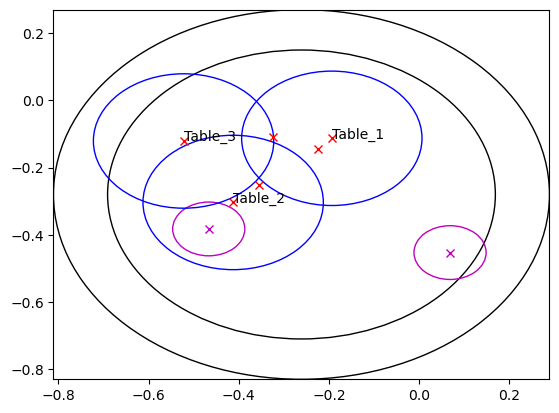

In [15]:

viewing = viewings[1]
print(viewing)

fixation_df = all_fix[all_fix.viewing_id == viewing].sort_values(by='start_time').reset_index(drop=True)

# taken from to_viewing.transition_features
df_list = [group for _, group in fixation_df.groupby('missing_split_group') if not group.empty]

for i in range(len(df_list)):
    fix_df = df_list[i].reset_index(drop=True)
    ext_fix_df = external_fixations(fix_df)

    external_df = ext_fix_df if i == 0 else pd.concat([external_df, ext_fix_df]).reset_index(drop=True)

# try:
#     prob_matrix, objects = transition_matrix(external_df, prob=True)
# except UnboundLocalError as e:
#     raise e
# print(prob_matrix)
# print(objects)

# print(external_df.shape)
# display(external_df.style)


import math
import pandas as pd

def calculate_distance(point1, point2):
    # Calculate Euclidean distance between two points
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def split_table_fixations_into_areas_of_interest(df,  radius=0.2):
    
    centroid_x_col, centroid_y_col, fixation_col = 'centroid_x', 'centroid_z', 'object'
    # print(fixation_col)
    table_fixations = df[df[fixation_col] == 'Table'].copy(deep=True)
    # print(table_fixations.shape)
    areas_of_interest = []
    
    if len(table_fixations) == 0:
        return df
    
    current_area = {
        "centroid": (table_fixations.loc[table_fixations.index[0], centroid_x_col], table_fixations.loc[table_fixations.index[0], centroid_y_col]),
        "fixations": [table_fixations.loc[table_fixations.index[0], fixation_col]],
        "indexes": [table_fixations.index[0]]
    }
    
    areas_of_interest.append(current_area)
    
    for i in table_fixations.index[1:]:
        is_inside_existing_area = False
        
        
        for area in areas_of_interest:
            centroid = area["centroid"]
            fixation = (table_fixations.loc[i, centroid_x_col], table_fixations.loc[i, centroid_y_col])
            
            if calculate_distance(fixation, centroid) <= radius:
                area["fixations"].append(table_fixations.loc[i, fixation_col])
                area["indexes"].append(i)
                is_inside_existing_area = True
                break
        
        if not is_inside_existing_area:
            # print(i)
            # print(table_fixations.index)
            new_area = {
                "centroid": (table_fixations.loc[i, centroid_x_col], table_fixations.loc[i, centroid_y_col]),
                "fixations": [table_fixations.loc[i, fixation_col]],
                "indexes": [i]
            }
            areas_of_interest.append(new_area)
    
    ax = plt.figure().add_subplot()
    table_x, table_z = (-0.2611119,-0.2797629)
    c = Circle((table_x, table_z), 0.55, fill=None)
    c2 = Circle((table_x, table_z ), 0.55-0.12, fill=None)
    ax.set_xlim((table_x-0.55, table_x+0.55))
    ax.set_ylim((table_z-0.55, table_z+0.55))
    ax.add_patch(c)
    ax.add_patch(c2)
    ax.plot(table_fixations.centroid_x, table_fixations.centroid_z, 'rx')
    non_table_fix = df[df[fixation_col] != 'Table'].copy(deep=True).reset_index(drop=True)
    ax.plot(non_table_fix.centroid_x, non_table_fix.centroid_z, 'mx')
    for i in range(len(non_table_fix)):
        c_aoi = Circle((non_table_fix.centroid_x[i], non_table_fix.centroid_z[i]), 0.08, fill=None, color='m')
        ax.add_patch(c_aoi)
        
    for i, area in enumerate(areas_of_interest):
        # print(area)
        c_fix = Circle((area["centroid"][0], area["centroid"][1]), radius, fill=None, color='b')
        ax.add_patch(c_fix)
        ax.annotate(f"Table_{i+1}", (area["centroid"][0], area["centroid"][1]))
    
    # Overwrite the original column with the new subregion area of interest
    # df[fixation_col] = df[fixation_col].where(df[fixation_col] != 'Table', "")
    for i in range(len(areas_of_interest)-1, -1, -1):
        area = areas_of_interest[i]
        new_obj_name = f"Table_{i+1}"
        
        # print(i)
        df.loc[df.index.isin(area["indexes"]), fixation_col] = new_obj_name
    
    return df

# print(external_df.object)
ext_df_table_adjust = split_table_fixations_into_areas_of_interest(external_df)
ext_df_re = external_fixations(ext_df_table_adjust)
# display(ext_df_table_adjust.style)
display(ext_df_re.style)


In [16]:
def transfer_entropy():
    pass

def stationary_entropy():
    pass

def stationary_distribution(cond_matrix):
    pass

def transition_entropy_2(prob_matrix):
    """
    calculates transition entropy by converting fixation/saccade dataframe into external fixation df.
    :param fix_df:
    :param pi_func: 
    objects
    :return:
    """

    # get conditional probability matrix
    cond_matrix = conditional_prob_matrix(prob_matrix)

    # get H from n fixations
    return shannon_entropy_alt(prob_matrix, cond_matrix)

In [19]:
# source linked further above has p(j|i) * log2(p(j|i)), whereas other sources have p(i, j) * log(p(j|i)) - test this out to see if there's a difference


# h1 = transition_entropy(prob_matrix, objects, external_df, n_fix)

trans_matrix, _ = transition_matrix(ext_df_re, prob=False, split_by_missing_group=False)
prob_matrix, objects = transition_matrix(ext_df_re, prob=True, split_by_missing_group=False)
h1a = transition_entropy(prob_matrix, objects, ext_df_re, n_fix)
h2 = transition_entropy_2(prob_matrix)
print(objects)
print(h1a, h2)

['5Ball' 'Pipe' 'Table_1' 'Table_2' 'Table_3']
0.375 0.2857142857142857


In [23]:
print(prob_matrix)
# areas of interest
n_objects = len(objects)


stationary_prob = np.zeros(n_objects)
total_denom = n_fix(ext_df_re, objects='total') - 1
print('n_fix', total_denom)
#
# prob_n_fixations = np.zeros(n_objects)
# total_n_fix = len(ext_fix_df)
# prob_dwell_time = np.zeros(n_objects)
# total_dwell_time = fix_sacc_calculations.dwell_time(ext_fix_df, 'total')
#
# if total_dwell_time < 6000 or 10000 < total_dwell_time:
#     print(f"invalid total dwell time: {total_dwell_time}")

for i in range(n_objects):
    numerator_prob = n_fix(ext_df_re, objects[i])
    stationary_prob[i] = numerator_prob/total_denom
# get conditional probability matrix
cond_matrix = conditional_prob_matrix(prob_matrix)
print(trans_matrix)
print(cond_matrix)
print(stationary_prob)

[[0.         0.         0.         0.14285714 0.        ]
 [0.         0.         0.14285714 0.         0.        ]
 [0.         0.         0.         0.14285714 0.14285714]
 [0.         0.         0.28571429 0.         0.        ]
 [0.14285714 0.         0.         0.         0.        ]]
n_fix 7
[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1.]
 [0. 0. 2. 0. 0.]
 [1. 0. 0. 0. 0.]]
[[0.  0.  0.  1.  0. ]
 [0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.5 0.5]
 [0.  0.  1.  0.  0. ]
 [1.  0.  0.  0.  0. ]]
[0.14285714 0.14285714 0.42857143 0.28571429 0.14285714]


In [ ]:
ax = plt.figure().add_subplot()
x = np.arange(0.01, 5, 0.01)
log2 = [-1 * np.log2(i) for i in x]
ln = [-1 * np.log(i) for i in x]
ax.plot(x, log2, 'b-')
ax.plot(x, ln, 'r-')
n = cond_matrix.shape[0]
for i in range(n):
    for j in range(n):
        if cond_matrix[i, j] != 0:
            ax.plot(cond_matrix[i, j], -1 * np.log2(cond_matrix[i, j]), 'gx')
            ax.plot(prob_matrix[i, j], -1 * prob_matrix[i, j] * np.log2(cond_matrix[i, j]), 'mx')
            
ax = plt.figure().add_subplot()
print(n)
for i in range(n):
    for j in range(n):
        if cond_matrix[i, j] != 0:
            ha = stationary_prob[i] * -p_log_p(cond_matrix[i, j])
            hb = -p1_log_p2(prob_matrix[i, j], cond_matrix[i, j])
            print(stationary_prob[i] * cond_matrix[i, j])
            print(prob_matrix[i, j])
            ax.plot(cond_matrix[i, j], ha, 'mo', alpha=0.5)
            ax.plot(cond_matrix[i, j], hb, 'r^', alpha=0.5)
            # ax.annotate(f"{cond_matrix[i, j]:.2f}, {stationary_prob[i]:.2f}, {prob_matrix[i, j]:.2f}", (-ha, -hb))